In [1]:
# Import statements for machine learning libraries and image classification
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [2]:
# Get file directory of images
data_dir = Path('../Images/chest_xray/All')

In [3]:
# Print total number of images
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

5856


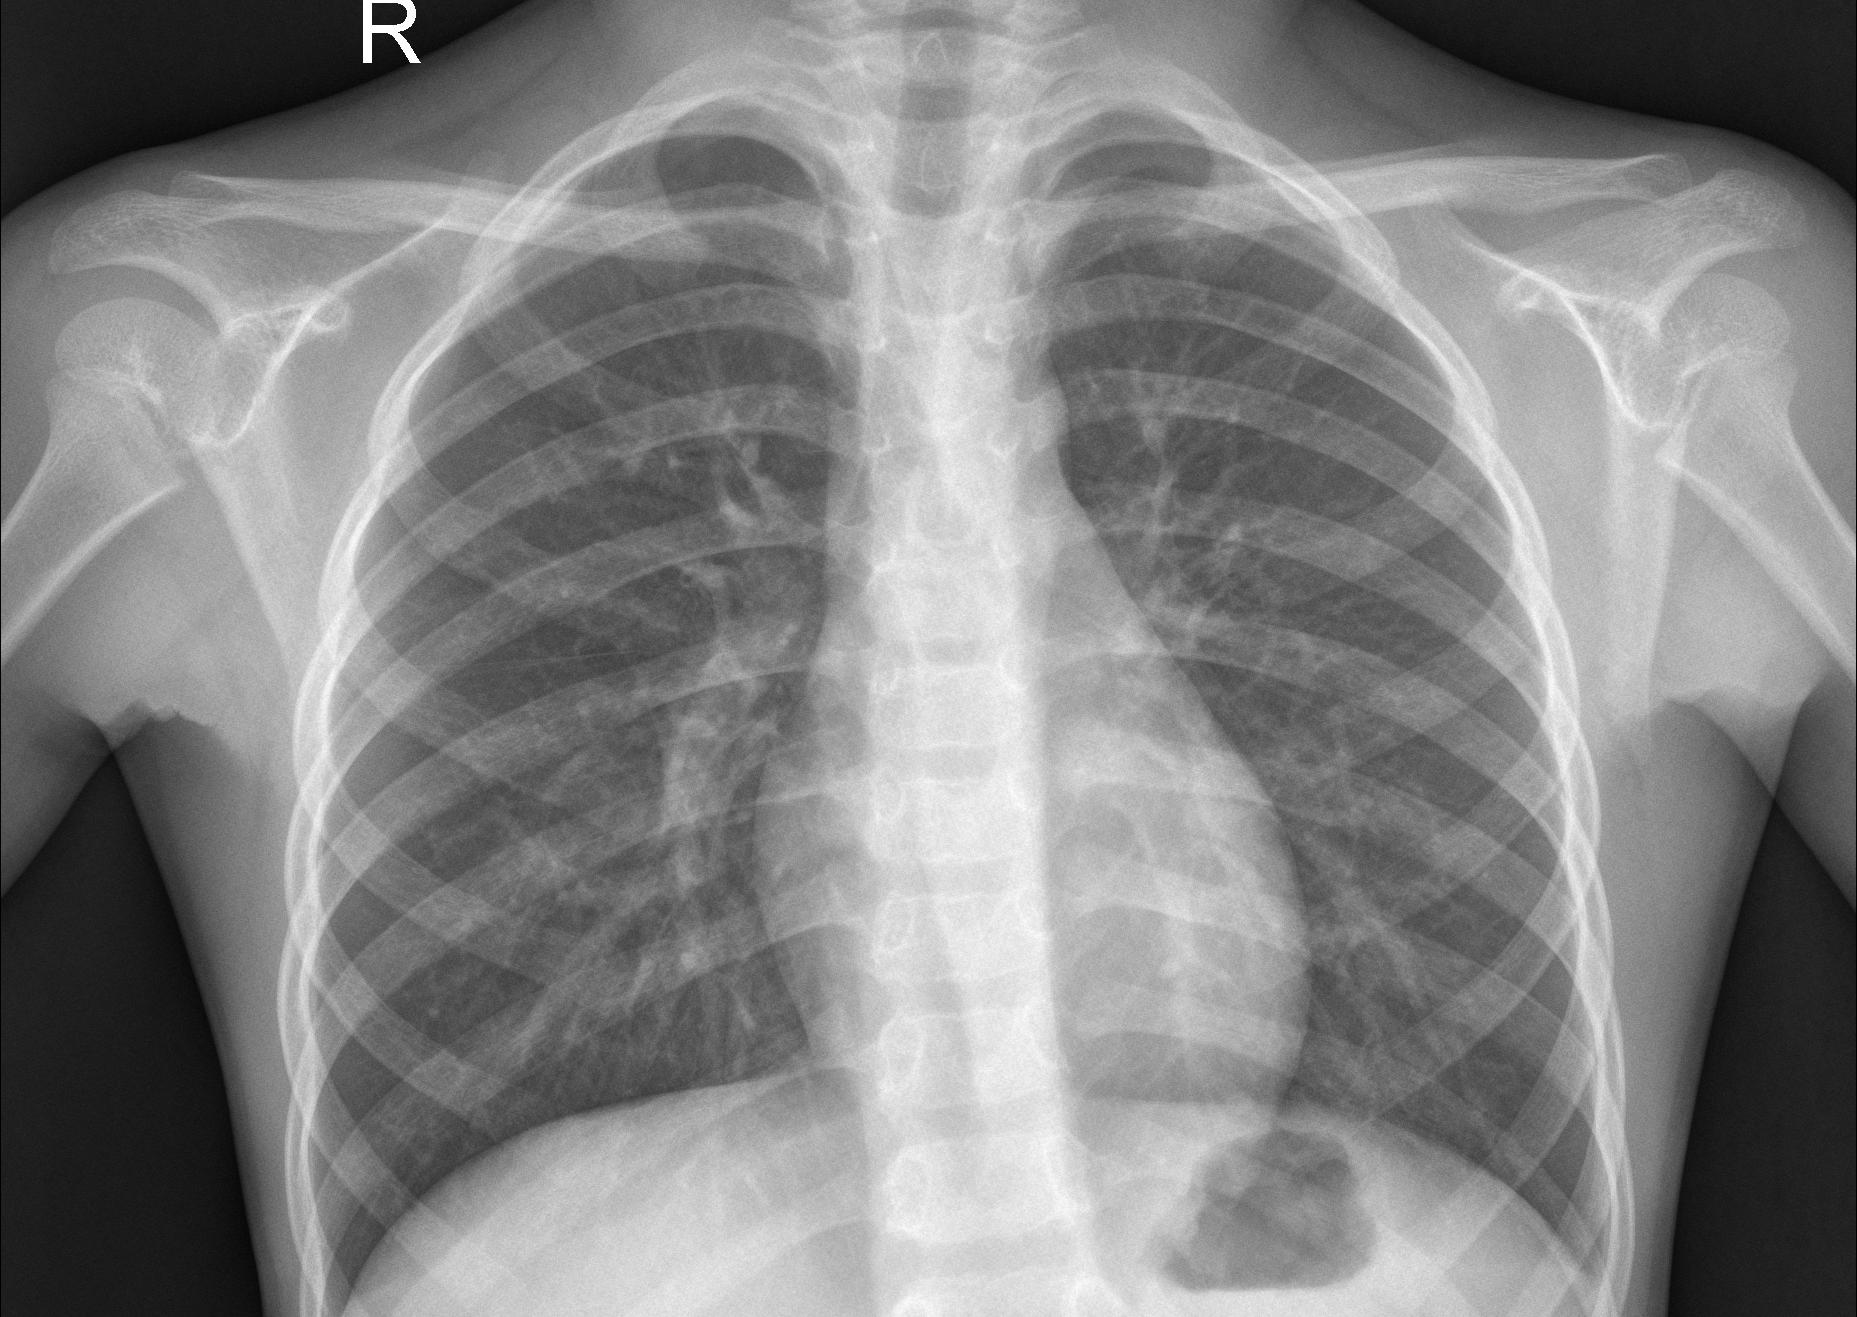

In [4]:
# Show Normal Lungs
normal_lungs = list(data_dir.glob('NORMAL/*'))
PIL.Image.open(str(normal_lungs[0]))

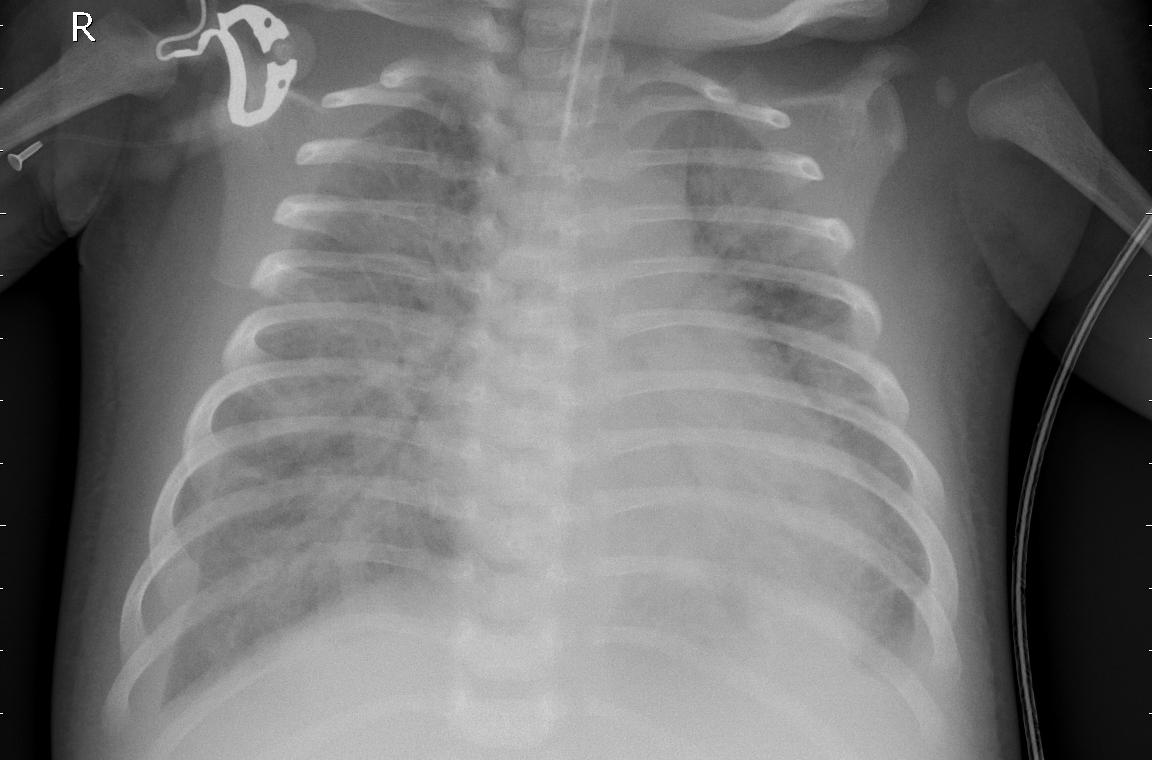

In [5]:
# Show Pneumonia Lungs
pneumonia_lungs = list(data_dir.glob('PNEUMONIA/*'))
PIL.Image.open(str(pneumonia_lungs[0]))

In [6]:
# Define image model parameters
batch_size = 32
img_height = 180
img_width = 180

## Load Image Training/Testing Data

In [7]:
# Preprocess Training Data
# Automatically labels image data based on file directories
# Note: Shuffle = True randomizes image sets each time the variable is called

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

Found 5856 files belonging to 2 classes.
Using 4685 files for training.


In [8]:
# Preprocess Testing Data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

Found 5856 files belonging to 2 classes.
Using 1171 files for validation.


In [9]:
# Show different outcomes
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


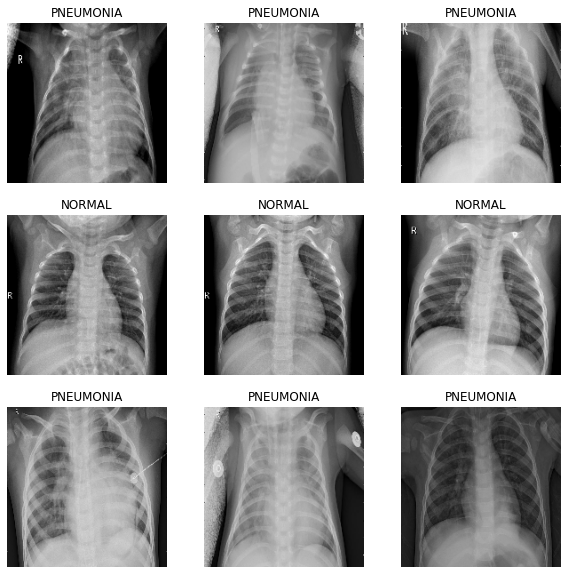

In [10]:
# Show sample of 9 images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [94]:
# For context of LEARNING this is the shape of the objects
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    
'''The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray'''

(32, 180, 180, 3)
(32,)


'The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.\n\nYou can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray'

In [95]:
# For context of LEARNING this is how you would use rescaled or normalized data layer based on image sizes
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

## Simple Model Creation

In [ ]:
# Creating a model
# In this model the image data is rescaled and then processed through 3 layers
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [97]:
# Compile the model showing the accuracy metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [98]:
# Model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

In [99]:
# Calculate class weights to balance problem as the dataset is inbalanced with too many pneumonia cases
y_test = np.concatenate([y for x, y in val_ds], axis=0)
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(y_test),y=y_test)

weight_for_0 = class_weights[0]
weight_for_1 = class_weights[1]

# Use class weights to balance model inputs
class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.03
Weight for class 1: 0.66


In [100]:
# Traing a simple model
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weights
)

Epoch 1/5
147/147 [==============================] - 82s 558ms/step - loss: 0.3237 - accuracy: 0.8534 - val_loss: 0.1494 - val_accuracy: 0.9411
Epoch 2/5
147/147 [==============================] - 82s 557ms/step - loss: 0.1709 - accuracy: 0.9334 - val_loss: 0.1542 - val_accuracy: 0.9436
Epoch 3/5
147/147 [==============================] - 82s 555ms/step - loss: 0.1485 - accuracy: 0.9422 - val_loss: 0.1389 - val_accuracy: 0.9513
Epoch 4/5
147/147 [==============================] - 82s 555ms/step - loss: 0.1262 - accuracy: 0.9507 - val_loss: 0.2146 - val_accuracy: 0.9317
Epoch 5/5
147/147 [==============================] - 81s 554ms/step - loss: 0.1057 - accuracy: 0.9584 - val_loss: 0.1549 - val_accuracy: 0.9462


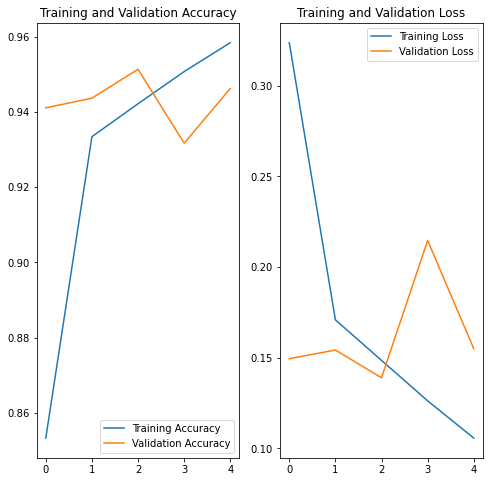

In [101]:
# Visualize the model using the history variable which has the accuracy metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Set the range based on the number of epochs
epochs_range = range(epochs)

# Plot a figure showing accuracy on training and testing datasets
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot a figure showing loss on training and testing dataset
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [102]:
# Saving the Model
model_name = 'basic_model-1-20-21'
model_path = Path(f'../Models/{model_name}')

model.save(model_path)

INFO:tensorflow:Assets written to: ..\Models\basic_model-1-20-21\assets


In [103]:
# Overfitting Advice
'''In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.'''

"In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.\n\nWhen there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.\n\nThere are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model."

In [27]:
# Use data augmentation to help with overfitting
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

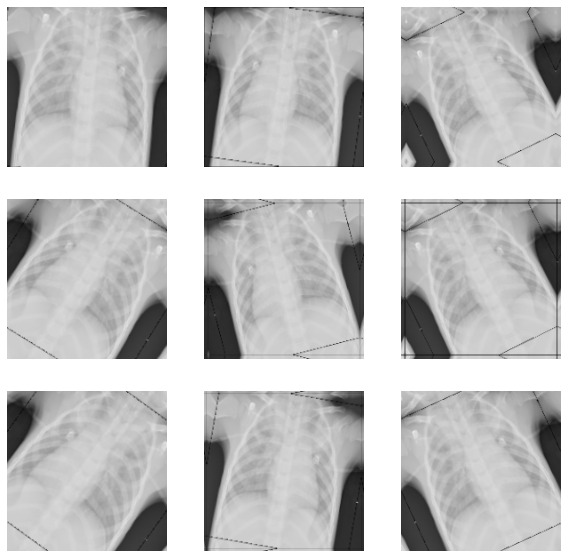

In [28]:
# Show what data augmentation is
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Create A Better Model

In [106]:
# Create a model that addresses overfitting which is common in image classification
# Use data_augmentation to generalize the model by flipping, rotating, and changing the images
# Use a dropout layer to randomly drop out nodes during training reducing overfitting
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [107]:
# Compile the model again
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [108]:
# Model summary 2.0
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

In [110]:
# Retrain improved model with many more epochs
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weights
)

Epoch 1/100
147/147 [==============================] - 102s 693ms/step - loss: 0.5548 - accuracy: 0.6619 - val_loss: 1.6525 - val_accuracy: 0.3775
Epoch 2/100
147/147 [==============================] - 94s 637ms/step - loss: 0.3401 - accuracy: 0.8508 - val_loss: 0.2637 - val_accuracy: 0.8941
Epoch 3/100
147/147 [==============================] - 91s 619ms/step - loss: 0.3187 - accuracy: 0.8604 - val_loss: 0.2768 - val_accuracy: 0.8847
Epoch 4/100
147/147 [==============================] - 91s 620ms/step - loss: 0.2583 - accuracy: 0.8918 - val_loss: 0.4125 - val_accuracy: 0.8480
Epoch 5/100
147/147 [==============================] - 91s 618ms/step - loss: 0.2316 - accuracy: 0.9025 - val_loss: 0.2971 - val_accuracy: 0.8873
Epoch 6/100
147/147 [==============================] - 91s 621ms/step - loss: 0.2366 - accuracy: 0.9027 - val_loss: 0.3145 - val_accuracy: 0.8822
Epoch 7/100
147/147 [==============================] - 91s 620ms/step - loss: 0.2240 - accuracy: 0.9106 - val_loss: 0.2225 

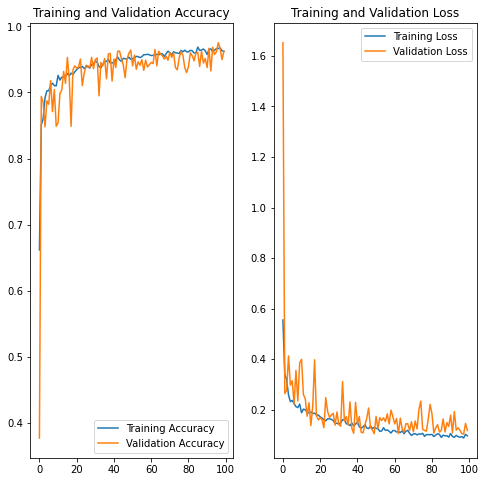

In [111]:
# Visualize the new model statistics with the same code from before
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [112]:
# Saving the Model
model_name = 'advanced_100_model-1-20-21'
model_path = Path(f'../Models/{model_name}')

model.save(model_path)

INFO:tensorflow:Assets written to: ..\Models\advanced_100_model-1-20-21\assets


In [ ]:
# Load desired model
model_name = 'advanced_100_model-1-20-21'
model_path = Path(f'../Models/{model_name}')
model = tf.keras.models.load_model(model_path)

## Analyzing Model Results

In [115]:
# Make predictions using test data and generate a classification report

y_pred = []
y_test = []

# Loop through testing data to make predictions paying special attention to final shapes of arrays for sklearn
for x, y in val_ds:
    y_pred = np.concatenate([y_pred,np.argmax(model.predict(x), axis=-1)])
    y_test = np.concatenate([y_test,y], axis=0)

# Print classification report from sklearn
print(classification_report(y_test, y_pred, target_names = ['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.89      0.97      0.93       288
   PNEUMONIA       0.99      0.96      0.97       883

    accuracy                           0.96      1171
   macro avg       0.94      0.97      0.95      1171
weighted avg       0.96      0.96      0.96      1171



In [ ]:
# Using a confusion matrix in tensorflow for LEARNING only as it is represented above with sklearn
tf.math.confusion_matrix(y_test, y_pred)

In [11]:
# Predict on the new model. A few other paths are shown for additional testing/display

# Define filepath variable
final_test_path = Path('../Images/chest_xray/val/normal/NORMAL2-IM-1430-0001.jpeg')
# final_test_path = Path('../Images/chest_xray/val/pneumonia/person1946_bacteria_4874.jpeg')
# final_test_path = Path('../Images/Predicted_Images/internet.jpg')

# Load image with keras and save to image array
img = keras.preprocessing.image.load_img(
    final_test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# Make a prediction on the image
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Create a print statement that shows the result and the confidence interval
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# Save the predicted image to a directory
img.save(f'../Images/Predicted_Images/internet - {class_names[np.argmax(score)]}.jpeg', 'JPEG')

This image most likely belongs to NORMAL with a 96.98 percent confidence.
